### Parallel News Aggregator with LLM + Langchain Tools
**Scenario:**

Build an AI-powered News Aggregator Agent using LangGraph.
The agent must fetch news from 3 sources simultaneously, then an LLM produces a final combined report.


In [61]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Optional, Any
from dotenv import load_dotenv
from utils import AWSLLM

In [91]:
import requests
from langchain.tools import tool
import feedparser

In [73]:
# define state
class NewsState(TypedDict):
    query: str
    newsapi: Optional[Any]
    google_news: Optional[Any]
    reddit_public: Optional[Any]

    final_response: Optional[str]

In [74]:
@tool
def reddit_news_tool(query: str):
    """Fetch only Reddit post content."""
    url = f"https://www.reddit.com/search.json?q={query}&sort=hot"
    headers = {"User-Agent": "NewsAgent/1.0"}
    resp = requests.get(url, headers=headers).json()

    posts = resp.get("data", {}).get("children", [])

    return [
        p["data"].get("selftext") or p["data"].get("title", "")
        for p in posts[:5]
        if p["data"].get("selftext") or p["data"].get("title")
    ]


In [ ]:
# create node funtions
def newsapi(state: NewsState):
    from langchain_community.tools import DuckDuckGoSearchRun

    ddg = DuckDuckGoSearchRun()
    query = state["query"]

    results = ddg.invoke({"query": query})

    return {"newsapi": results}

def google_news(state: NewsState):
    import re
    import html
    query = state["query"]
    url = f"https://news.google.com/rss/search?q={query}"

    resp = requests.get(url)
    feed = feedparser.parse(resp.text)

    cleaned = []
    for entry in feed.entries[:5]:
        summary = entry.get("summary", "")
        if not summary:
            continue
        text = re.sub(r"<.*?>", "", summary)

        text = html.unescape(text).strip()

        cleaned.append(text)

    return {"google_news": cleaned}

def raddit_public(state: NewsState):
    query = state["query"]
    result = reddit_news_tool.invoke({"query": query})
    return {"reddit_public": result}



def final_response(state: NewsState):
    api = state['newsapi']
    google = state["google_news"]
    reddit = state['reddit_public']

    llm = AWSLLM()

    prompt = f"""
    You are a news summarizer. Combine the following news items into a single,
    coherent, well‑structured summary. Avoid repetition. Highlight key themes,
    trends, and insights. Keep it concise but informative.

    ### NewsAPI Articles:
    {api}

    ### Google News Articles:
    {google}

    ### Reddit Discussions:
    {reddit}

    Now produce a final unified summary.
    """

    response = llm.chat(prompt)

    return {"final_response": response}


In [ ]:
# Define graph
graph = StateGraph(NewsState)

# add nodes
graph.add_node('newsapi', newsapi)
graph.add_node('google_news', google_news)
graph.add_node('raddit_public', raddit_public)
graph.add_node('final_response', final_response)

# add edges
graph.add_edge(START, 'newsapi')
graph.add_edge(START, 'google_news')
graph.add_edge(START, 'raddit_public')

graph.add_edge('newsapi', 'final_response')
graph.add_edge('google_news', 'final_response')
graph.add_edge('raddit_public', 'final_response')

graph.add_edge('final_response', END)


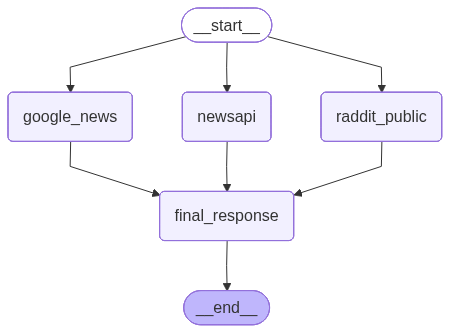

In [88]:
# initialize the workflow
workflow = graph.compile()

workflow

In [89]:
# execute the workflow
query = {'query': 'ai treads today'}
response = workflow.invoke(query)

In [90]:
response

{'query': 'ai treads today',
 'newsapi': "According to The Rundown AI , recent developments in the AI industry include OpenAI's new report highlighting significant enterprise adoption and measurable business wins, such as improved efficiency and cost savings for corporate clients (source: therundown. ai ). Google announced plans to launch AI ... Nov 14, 2025 · Stay informed with daily insights on artificial intelligence trends and expert analysis. Discover what experts predict about AI 's future. Updated daily. Wall Street's concentration in the red-hot tech sector is, by some measures, greater than it has ever been, eclipsing levels hit during the 1990s dotcom bubble. But does this mean history is bound ... 2 days ago · AI industry news and trends today from NeurIPS 2025. Top insights about AI industry. The Sejnowski-Hinton Prize Read the latest on artificial intelligence and machine learning tech, the companies that are building them, and the ethical issues AI raises today .",
 'goog